In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
sys.path.append('/glade/work/fanda/util/ams-ml-python-course')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-04-05 12:59:04.292799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.
2023-04-05 12:59:16.082320: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-05 12:59:16.083625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-05 12:59:16.128243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-05 12:59:16.128275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-05 12:59:16.147476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-05 12:59:16.147559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic l

In [3]:
# Load test data
import scipy.io as scio
test_data = scio.loadmat('test_data/test_lead10.mat')
test_data_scaled=test_data["test_data_scaled"]
test_label=test_data["test_label"][0,:]

# Load resnet model
i = 0
resnet = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)

# Load logistic model
with open('echo_log_lead_time/10min/Logistic_regression_optimal.pkl', 'rb') as f:
    log = pickle.load(f)

In [4]:
# Flattened test data for logistic model
test_data_scaled_flatten = test_data_scaled.reshape((-1,7168))

In [5]:
resnet_preds = resnet.predict(test_data_scaled)[:,0]
log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]

2023-04-05 12:59:55.560756: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-05 12:59:55.561402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-04-05 12:59:55.792737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-05 12:59:56.126081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-05 12:59:56.127880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [64]:
# Resample data (bootstrap)
from sklearn.utils import resample
from module_4 import performance_diagrams_8
n_samples = 100
ci = (2.5, 97.5)
resnet_bootstrap_perf_diagram = np.zeros((1003,n_samples, 2))
for i in range(n_samples):
    resnet_preds_bootstrap, resnet_labels_bootstrap = resample(resnet_preds, test_label, replace=True)
    pod_by_threshold, success_ratio_by_threshold = performance_diagrams_8.get_points_in_perf_diagram(
        observed_labels=resnet_labels_bootstrap,
        forecast_probabilities=resnet_preds_bootstrap)
    resnet_bootstrap_perf_diagram[:,i,0] = pod_by_threshold
    resnet_bootstrap_perf_diagram[:,i,1] = success_ratio_by_threshold
#plt.fill(pofd_poly, pod_poly, alpha=0.5, color=colors[b])

In [112]:
#broc_curves = np.dstack([b_roc.roc_curve().values for b_roc in b_set])
pod_range = np.percentile(resnet_bootstrap_perf_diagram[:,:, 0], ci, axis=1)
sr_range = np.percentile(resnet_bootstrap_perf_diagram[:,:, 1], ci, axis=1)
pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
pod_poly[np.isnan(pod_poly)] = 0
sr_poly[np.isnan(sr_poly)] = 1

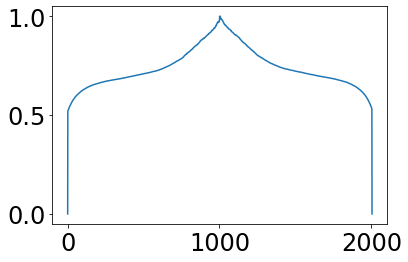

In [197]:
plt.plot(sr_poly)

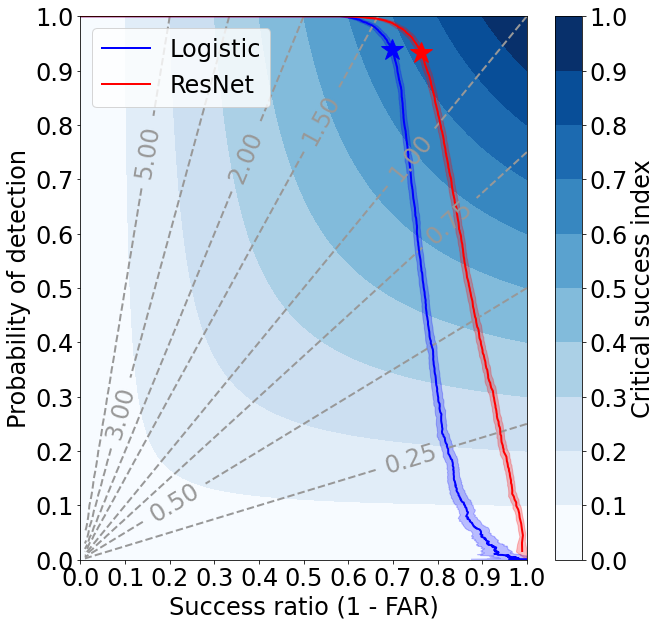

In [18]:
from module_4 import performance_diagrams_26 as performance_diagrams
POD, CSI = performance_diagrams.plot_performance_diagram(test_label,log_preds,resnet_preds, n_samples=1000)#000
#plt.title('Performance diagram')
plt.savefig('plots/Performance_diagram.png')

In [5]:
import roc_utils
n_samples=1000
resnet_bootstrap = roc_utils.compute_roc_bootstrap(resnet_preds, test_label, True, n_bootstrap=n_samples, random_state=42, return_mean=False)

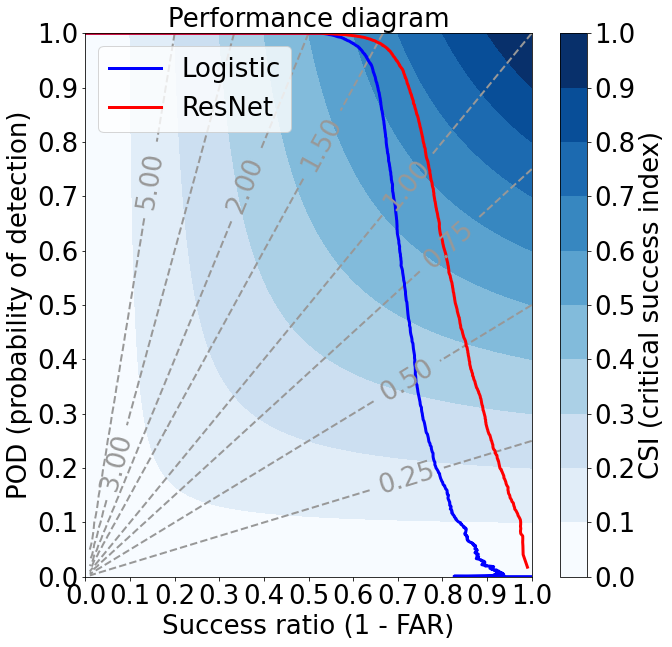

In [25]:
from module_4 import performance_diagrams_8
POD, CSI = performance_diagrams_8.plot_performance_diagram(test_label,log_preds,resnet_preds)
plt.title('Performance diagram')
plt.savefig('plots/Performance_diagram.png')

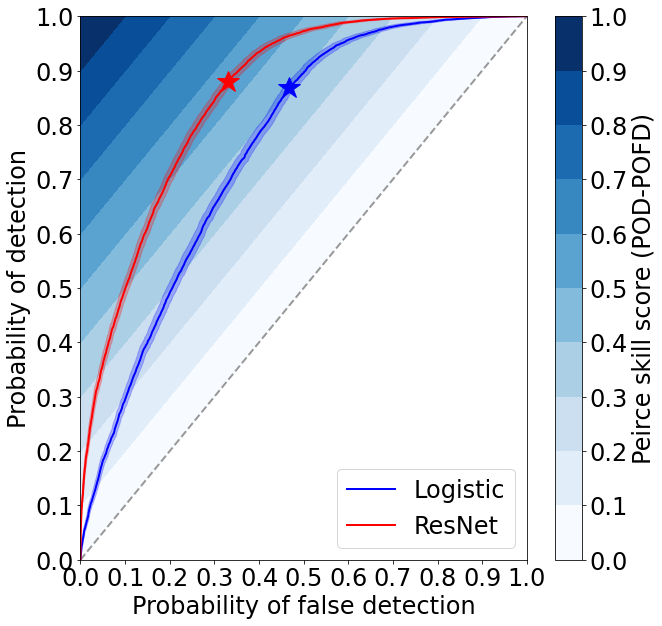

In [21]:
from module_4 import roc_curves_test11
AUC=roc_curves_test11.plot_roc_curve(test_label,log_preds,resnet_preds, n_samples=1000)#)00)
#plt.title('ROC curve')
plt.savefig('plots/ROC_curve.png')

(array([0.04640556, 0.13346121, 0.22722118, 0.31827113, 0.41148075,
        0.505243  , 0.59725702, 0.67998755, 0.7630747 , 0.85919726,
        0.94219756]),
 array([0.04259502, 0.12311015, 0.24774266, 0.36807388, 0.48150289,
        0.55623209, 0.60332779, 0.667882  , 0.73963806, 0.83805031,
        0.89183223]),
 array([3052, 2315, 1772, 1516, 1730, 2792, 6010, 9051, 3426, 1272,  453]))

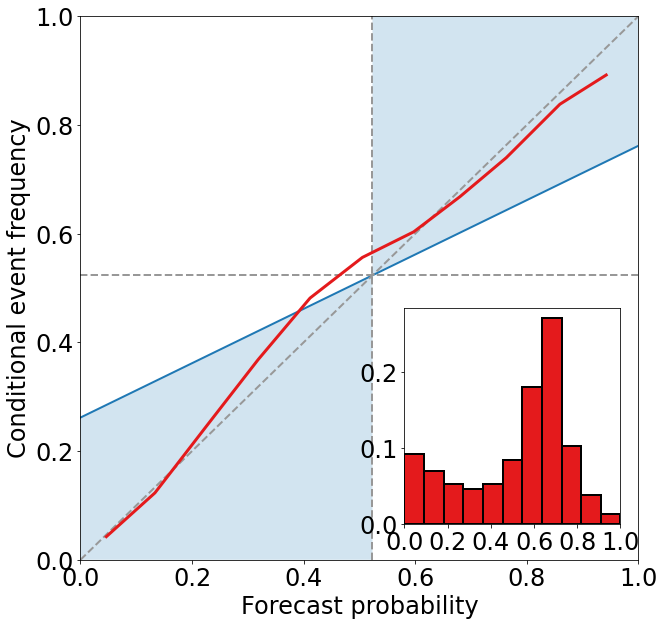

In [166]:
from module_4 import attributes_diagrams as attributes_diagrams
attributes_diagrams.plot_attributes_diagram(test_label, log_preds)

In [13]:
from module_4 import attributes_diagrams as attributes_diagrams

0.058813568471243985
0.0009578171959116904
0.23722183802468683


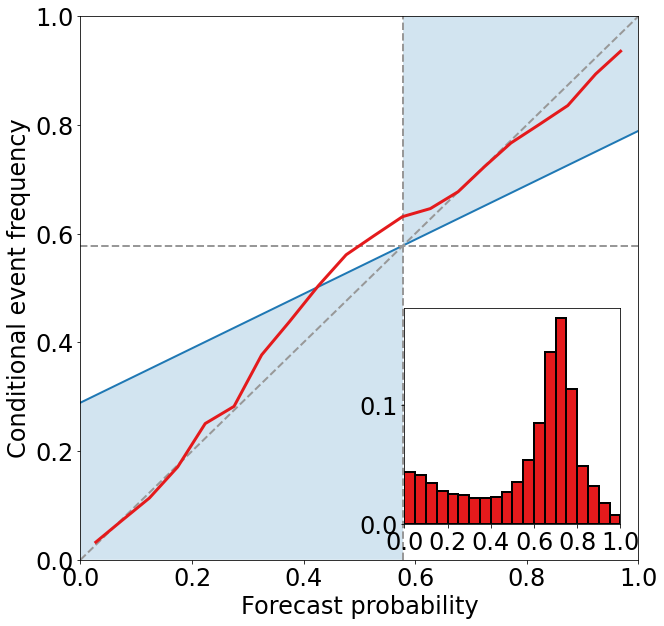

In [14]:
    target_values=test_label
    forecast_probabilities=log_preds
    mean_forecast_by_bin, event_freq_by_bin, num_examples_by_bin = (
        attributes_diagrams.plot_attributes_diagram(
            observed_labels=target_values,
            forecast_probabilities=forecast_probabilities, num_bins=20)
    )

    event_frequency = np.mean(target_values)
    uncertainty = event_frequency * (1. - event_frequency)

    this_numerator = np.nansum(
        num_examples_by_bin * (mean_forecast_by_bin - event_freq_by_bin) ** 2
    )
    reliability = this_numerator / np.sum(num_examples_by_bin)

    this_numerator = np.nansum(
        num_examples_by_bin * (event_freq_by_bin - event_frequency) ** 2
    )
    resolution = this_numerator / np.sum(num_examples_by_bin)
    print(resolution)
    print(reliability)
    # brier_score = uncertainty + reliability - resolution
    brier_skill_score = (resolution - reliability) / uncertainty
    print(brier_skill_score)

0.0986917178613307
0.005662338965388748
0.38144177139740393


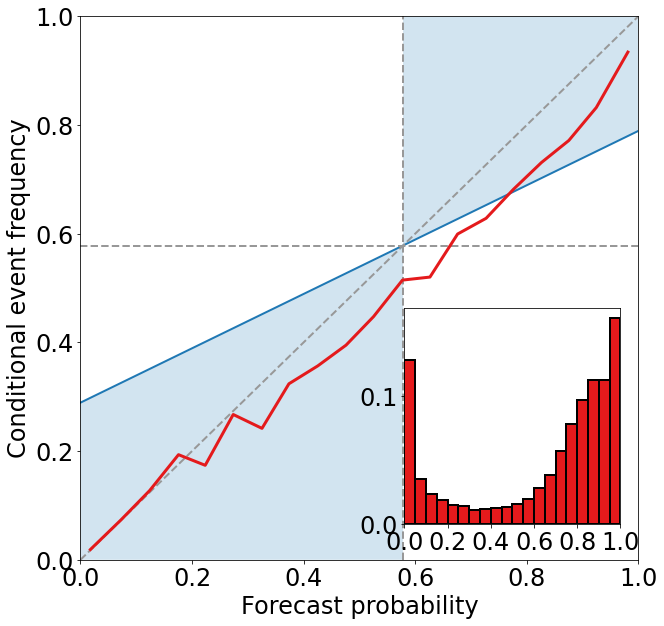

In [15]:
    target_values=test_label
    forecast_probabilities=resnet_preds
    mean_forecast_by_bin, event_freq_by_bin, num_examples_by_bin = (
        attributes_diagrams.plot_attributes_diagram(
            observed_labels=target_values,
            forecast_probabilities=forecast_probabilities, num_bins=20)
    )

    event_frequency = np.mean(target_values)
    uncertainty = event_frequency * (1. - event_frequency)

    this_numerator = np.nansum(
        num_examples_by_bin * (mean_forecast_by_bin - event_freq_by_bin) ** 2
    )
    reliability = this_numerator / np.sum(num_examples_by_bin)

    this_numerator = np.nansum(
        num_examples_by_bin * (event_freq_by_bin - event_frequency) ** 2
    )
    resolution = this_numerator / np.sum(num_examples_by_bin)
    print(resolution)
    print(reliability)
    # brier_score = uncertainty + reliability - resolution
    brier_skill_score = (resolution - reliability) / uncertainty
    print(brier_skill_score)

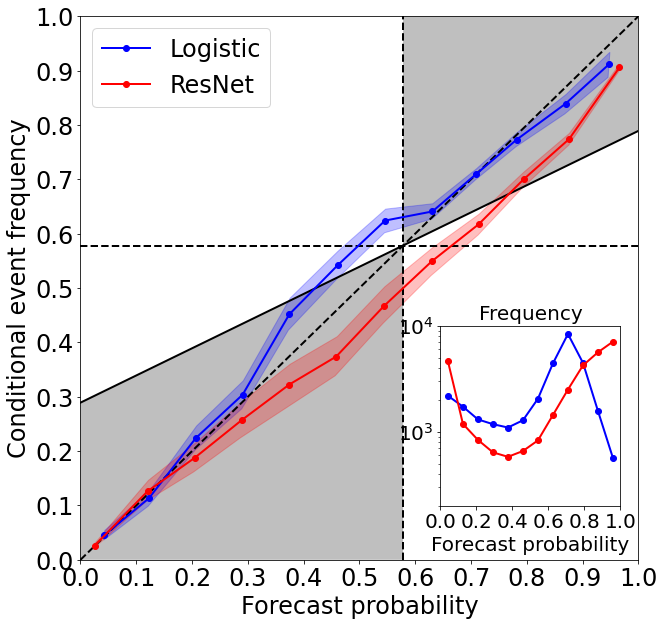

In [22]:
from module_4 import attributes_diagrams_36 as attributes_diagrams
attributes_diagrams.plot_attributes_diagram(test_label, log_preds, resnet_preds, n_samples=1000)
plt.savefig('plots/Attribute_diagram.png')

In [19]:
bin_frequencies = np.array([2826, 2200, 1668, 1450, 1447, 1922, 3553, 7270, 7251, 2343, 1065,394])

In [59]:
print(1e2)

100.0


In [14]:
forecast_bin_edges = np.linspace(0, 1, num=12 + 1, dtype=float)
forecast_bin_width = forecast_bin_edges[1] - forecast_bin_edges[0]
forecast_bin_centers = forecast_bin_edges[:-1] + forecast_bin_width / 2

In [20]:
HISTOGRAM_Y_TICK_SPACING = 0.1

def _floor_to_nearest(input_value_or_array, increment):
    """Rounds number(s) down to the nearest multiple of `increment`.

    :param input_value_or_array: Input (either scalar or numpy array).
    :param increment: Increment (or rounding base -- whatever you want to call
        it).
    :return: output_value_or_array: Rounded version of `input_value_or_array`.
    """

    return increment * np.floor(input_value_or_array / increment)

max_y_tick_value = _floor_to_nearest(
    1.05 * np.max(bin_frequencies), HISTOGRAM_Y_TICK_SPACING)
num_y_ticks = 1 + int(np.round(
    max_y_tick_value / HISTOGRAM_Y_TICK_SPACING
))

In [42]:
bin_frequencies

array([2826, 2200, 1668, 1450, 1447, 1922, 3553, 7270, 7251, 2343, 1065,
        394])

([<matplotlib.axis.YTick at 0x2aaedac2f890>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

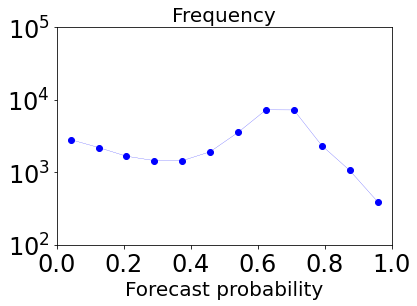

In [47]:
import matplotlib.pyplot as pyplot
pyplot.plot(forecast_bin_centers, bin_frequencies, color='b',marker='o',linestyle='solid', linewidth=0.2)
pyplot.xlim(0, 1)
pyplot.ylim(100, int(10000))
pyplot.yscale('log')
pyplot.xlabel('Forecast probability', fontsize=20)
pyplot.title('Frequency', fontsize=20)
pyplot.xticks(np.arange(0, 1.1, 0.2))
pyplot.yticks([10e1,10e2,10e3,10e4])
##inset_axes_object.set_yticks(numpy.arange(0, 0.21, 0.05))
#pyplot.xticklabels([str(round(i,2)) for i in np.arange(0.0, 1.1, 0.2)], fontsize=20)

In [36]:
int(1.05 * np.max(bin_frequencies))

7633